# This notebook is to determine the effects of the density step size on the amplitude of the shock

In [1]:
import numpy as np
import pandas as pd
import itertools
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
colorlist = list(matplotlib.colors.TABLEAU_COLORS)
import simplesimdb as simplesim
from netCDF4 import Dataset
import feltorutilities as fp

from methods.SolutionClass2 import SolutionClass
from methods.make_input import make_plasma_input
from methods.save_load_data2 import save_data, load_data
from methods.wavefront import get_wavefront_datapoint

#### Parameters

In [ ]:
p_list = []

params = make_plasma_input()
x_len = params["grid"]["x"][-1]-params["grid"]["x"][0]

params["grid"]["Nx"]= 400
params["output"]["maxout"] = 100
params["output"]["tend"] = 4e3
params["init"]["type"] = "soft-step"
params["init"]["x_a"] = -0.0
params["init"]["alpha"] = 0.001
params["init"]["n_l"] = 1
params["init"]["n_r"] = 0.2
params["init"]["t_l"] = 1
params["init"]["t_r"] = 0.2
params["timestepper"]["type"] = "ARK"
params["timestepper"]["tableau"]  = "ARK-4-2-3"
params["poisson"]["eps"]= 1e-12
params["poisson"]["type"] = "anderson"
params["poisson"]["damping"] = 1e-1
params["physical"]["type"] = "adiabatic"
params["physical"]["resistivity"] = 0.0

params["advection"] = {"type" : "staggered", "variant" : "slope-limiter-explicit"}
params["timestepper"]["rtol"] = 1e-5

#params["bc"]["density"] = "PER"
#params["bc"]["velocity"] = "PER"
#params["bc"]["pressure"] = "PER"
#params["bc"]["potential"] = "DIR"

In [ ]:
if False:
    i = 0
    for nrel in [0.2, 0.3, 0.4, 0.5]:
        for trel in [0.2, 0.3, 0.4, 0.5]:
            for namp in [0.8, 1.2, 1.6, 2.0]:
                for Tamp in [0.8, 1.2, 1.6, 2.0]:
                    i += 1
                    print(f"{i}/256")
                    params = copy.deepcopy(params)
                    params["init"]["n_l"] = namp
                    params["init"]["t_l"] = Tamp
                    params["init"]["n_r"] = namp*nrel
                    params["init"]["t_r"] = Tamp*trel
                    sol = SolutionClass(params)
                    save_data(sol, filename=f"DATA/Shock-shape/n={namp}, T={Tamp}, nrel={nrel}, trel={trel}")

#### Loading data

In [ ]:
sols = np.empty((4,4,4,4),dtype=SolutionClass)
for i, nrel in enumerate([0.2, 0.3, 0.4, 0.5]):
    for j, trel in enumerate([0.2, 0.3, 0.4, 0.5]):
        for k, namp in enumerate([0.8, 1.2, 1.6, 2.0]):
            for l, Tamp in enumerate([0.8, 1.2, 1.6, 2.0]):
                sols[i][j][k][l] = load_data(filename=f"DATA/Shock-shape/n={namp}, T={Tamp}, nrel={nrel}, trel={trel}")

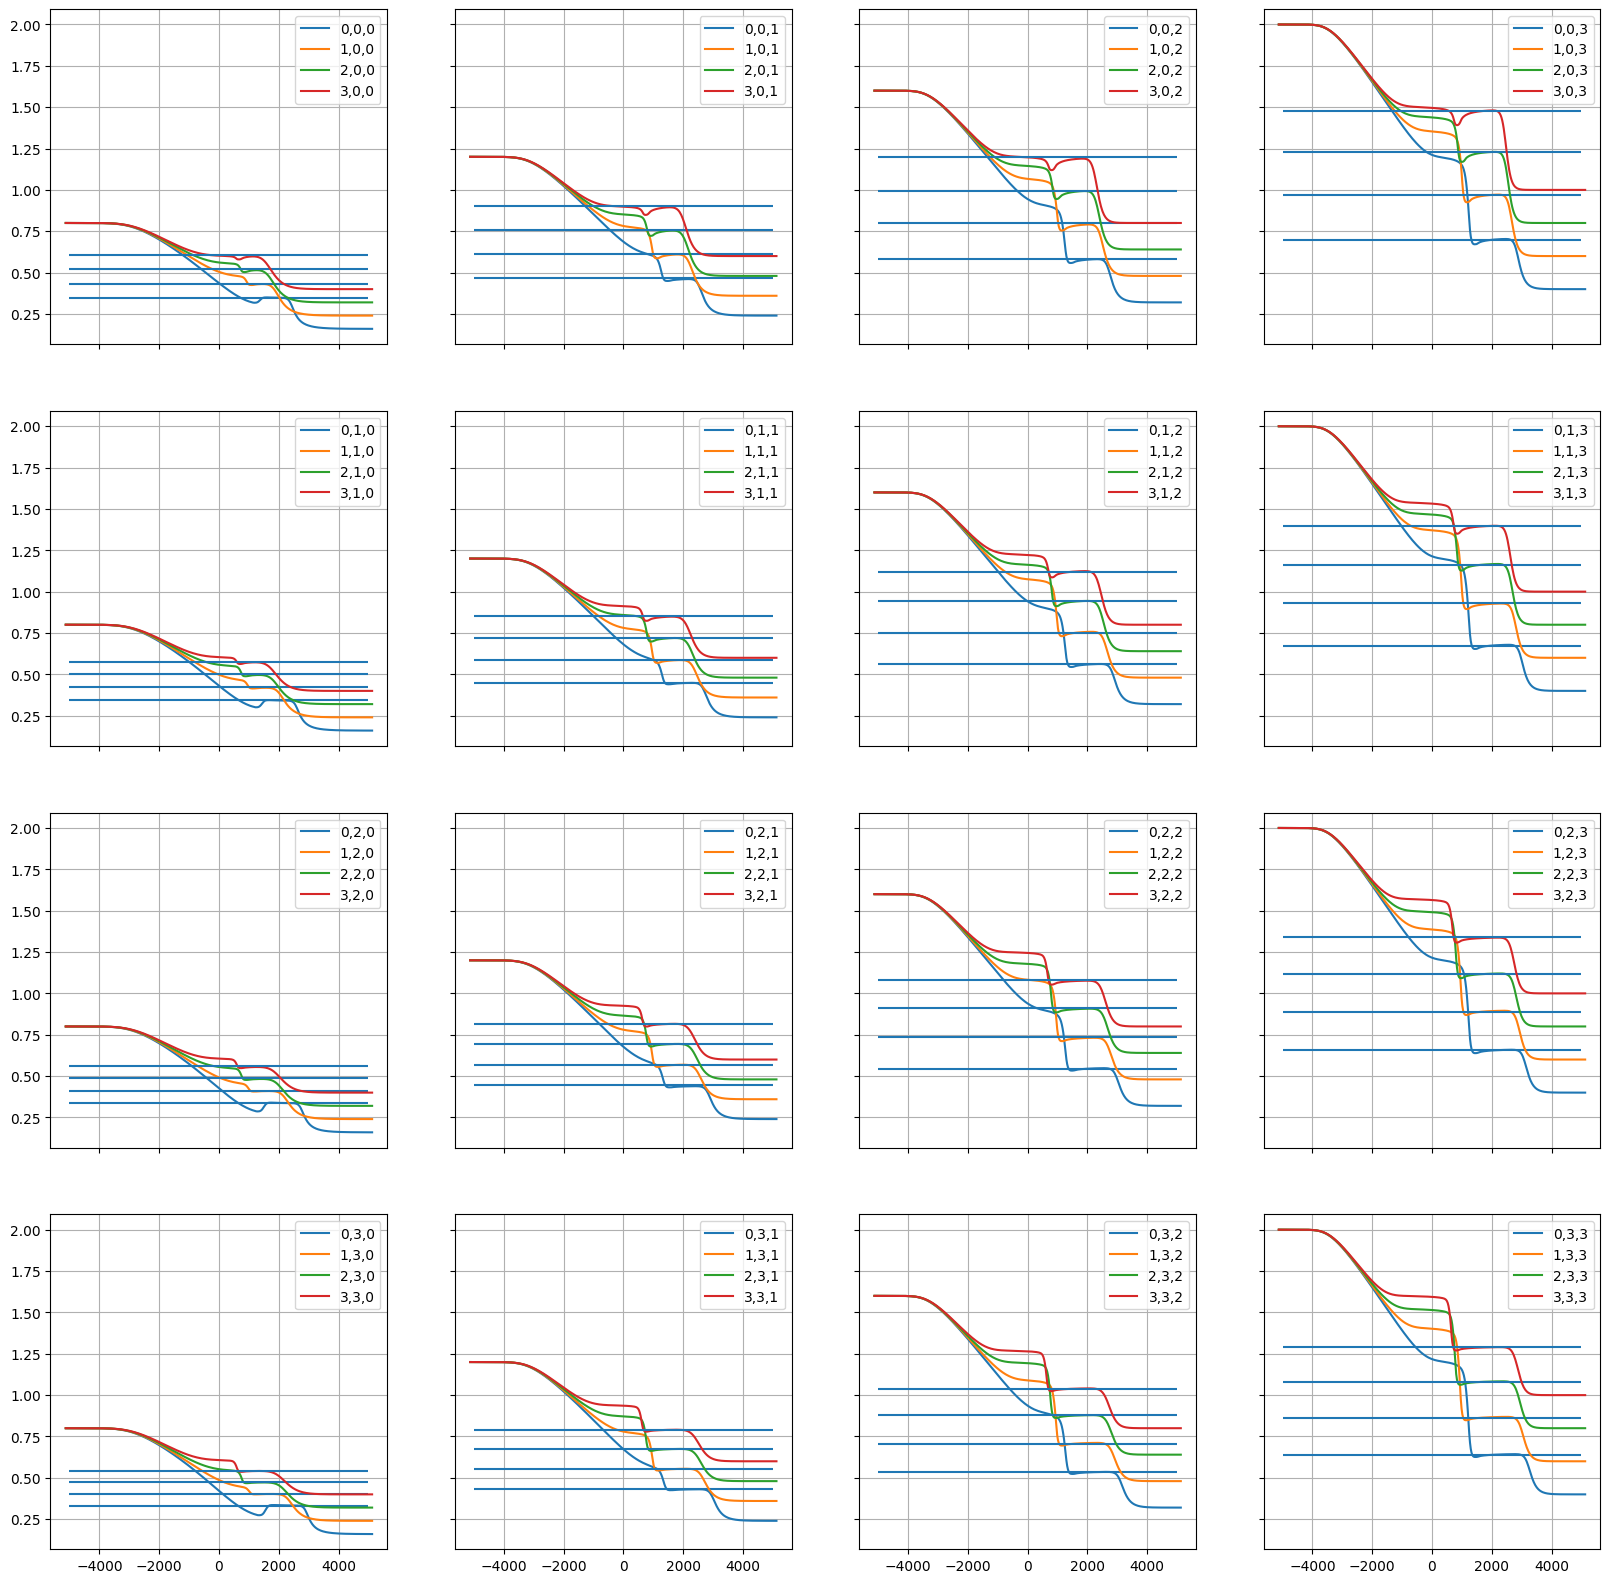

In [48]:
yn = 4
fig, ax = plt.subplots(yn, 4, figsize=(20, 5*yn), sharex=True, sharey=True)
heights = np.array([
    [[0.435,0.39,0.365,0.348],
     [0.43,0.375,0.35,0.335],
     [0.42,0.37,0.34,0.33],
     [0.415,0.36,0.335,0.32]],
    [[0.54,0.51,0.50,0.485],
     [0.528,0.490,0.47,0.465],
     [0.51,0.475,0.46,0.445],
     [0.5,0.46,0.44,0.43]],
    [[0.65,0.63,0.62,0.615],
     [0.63,0.6,0.59,0.58],
     [0.61,0.58,0.57,0.56],
     [0.59,0.56,0.55,0.54]],
    [[0.755,0.75,0.75,0.74],
     [0.72,0.71,0.7,0.698],
     [0.70,0.68,0.675,0.67],
     [0.68,0.66,0.65,0.645]],
])
nrels = np.empty((4,4,4))
trels = np.empty((4,4,4))
namps  = np.empty((4,4,4))
for i in range(4):
    for j in range(4):
        for k in range(4):
            sol = sols[i][j][k][0]
            nrels[i][j][k] = sol.params["init"]["n_r"] / sol.params["init"]["n_l"]
            trels[i][j][k] = sol.params["init"]["t_r"] / sol.params["init"]["t_l"]
            namps[i][j][k] = sol.params["init"]["n_l"]


            ti = 40
            x  = sol.data_full["x"]
            ni = sol.data_full["ni"]
            nl = sol.params["init"]["n_l"]
            nr = sol.params["init"]["n_l"]
            tl = sol.params["init"]["t_l"]
            tr = sol.params["init"]["t_r"]

            factor = nl/nr

            ax[j][k].plot(x, ni[ti]*factor, label=f"{i},{j},{k}")
            ax[j][k].hlines(heights[i][j][k]*nl*factor, -5000,5000)
            ax[j][k].grid(True)
            ax[j][k].legend()

In [75]:
from scipy.optimize import curve_fit

h = heights.flatten()
dpoints = []
for nr, tr, n in zip(nrels.flatten(), trels.flatten(), namps.flatten()):
    dpoints.append(np.array([n, nr, tr]))

dpoints = np.array(dpoints)

def f(X, a, A, b, B, c, C, d, i, j, k):
    n, nr, tr = X
    
    return n*a + n**2*A + nr*b + nr**2*B + tr*c + tr**2*C + d + i*n*nr + j*n*tr + k*nr*tr

params, cov = curve_fit(f, dpoints.T, h, p0=[1,1,1,1,1,1,1, 1, 1, 1])
print(params)

[-0.19246564  0.03457032  1.1750623  -0.1281247  -0.07197496  0.23749993
  0.34346378  0.178375   -0.03699998 -0.67850003]


(0.0, 0.7)

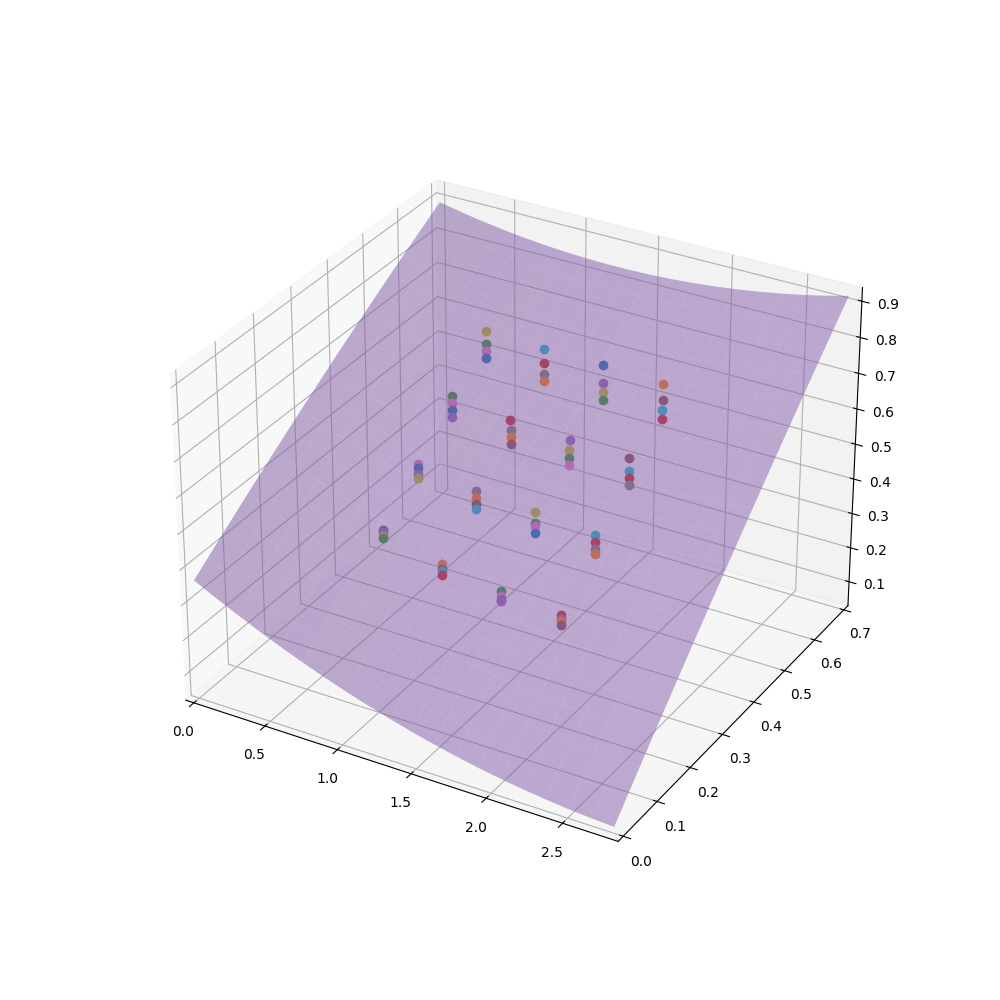

In [76]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(10,10), subplot_kw={"projection": "3d"})

x = np.linspace(0,2.8, 20)
y = np.linspace(0,0.7, 20)
x,y = np.meshgrid(x,y)


for point, h in zip(dpoints, heights.flatten()):
    ax.plot(point[0], point[1], h, 'o')

Z = f((x,y,0.5),*params)

ax.plot_surface(x,y,Z, alpha=0.5)
ax.set_xlim(0,2.8)
ax.set_ylim(0,0.7)

AttributeError: 'numpy.ndarray' object has no attribute 'params'

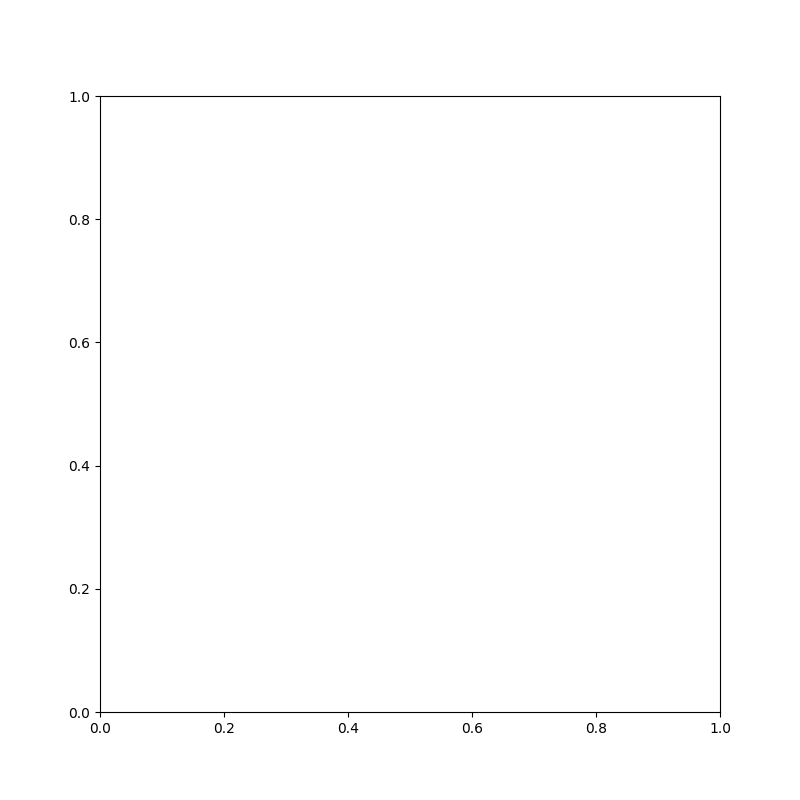

In [77]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

tis = [int(480/sol.params["init"]["t_l"]) for sol in sols]
ni_inits = []
for sol, ti in zip(sols, tis):
    x  = sol.data_full["x"]
    t  = sol.data_full["t"]
    Ti_avg = (sol.params["init"]["t_l"]*sol.params["init"]["n_l"] + sol.params["init"]["t_r"]*sol.params["init"]["n_r"])/(sol.params["init"]["n_l"]*sol.params["init"]["n_r"])
    ni_init = (sol.params["init"]["n_l"] + sol.params["init"]["n_r"])/0.5
    ni_inits.append(ni_init)
    ni = sol.data_full["ni"]

    ax.plot(x, ni[ti]/ni_init)

ax.grid(True)
ax.set_ylim(0.05,0.25)

heights = [0.098, 0.108, 0.119, 0.132, 0.148, 0.169, 0.194, 0.223]

ax.hlines(heights, 0, 5000)

plt.show()

In [ ]:
Ti_avg = [(sol.params["init"]["t_l"]*sol.params["init"]["n_l"] + sol.params["init"]["t_r"]*sol.params["init"]["n_r"])/(sol.params["init"]["n_l"]*sol.params["init"]["n_r"]) for sol in sols]

plt.plot(ni_inits, np.array(heights),'o')